In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import ipywidgets as widgets  # not used, for future
from IPython.display import display
import nglview as nv
from io import StringIO
import time
import pandas as pd

In [6]:
def pos2pdb(positions):
    pdb_str = "MODEL\n"
    for i, pos in enumerate(positions):
        pdb_str += f"ATOM  {i+1:5d}  CA  ALA A{i+1:4d}    {pos[0]:8.3f}{pos[1]:8.3f}{0.0:8.3f}  1.00  0.00           C  \n"
    pdb_str += "ENDMDL\n"
    return pdb_st

In [7]:
start_time = time.time()

id = 21072500

def student_id_to_initial_T(id):
 r = id % 10000000
 return (r / 10000000) * 6 + 1
T = student_id_to_initial_T(id)
N = 100  # Number of atoms
d = 2  # a 2D system
rho = 0.8  # The (reduced units) density (in 2D)

T0 = T  # Reduced temperature (in reduced units)
Ti = T0  # Initial Temperature (in reduced units)
# the Interatomic Potential (a special case of a Materials Relation)
epsilon = 1.0
sigma = 1.0
dt = 0.0025
max_steps = 2000
print(T0,T)

1.6435 1.6435


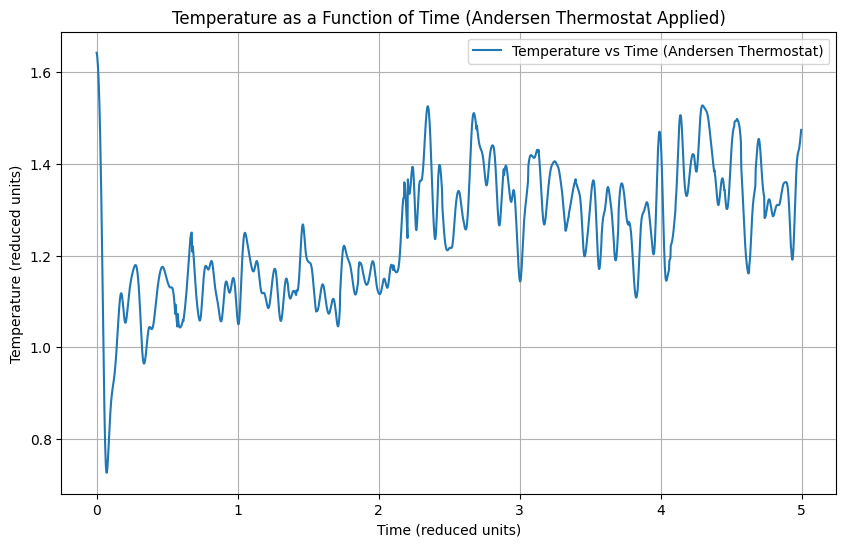

In [8]:
# Andersen Thermostat 参数
collision_frequency = 0.1  # 碰撞频率 ν

# 初始化模拟盒和粒子的位置、速度等
L = np.sqrt(N / rho)  # length of the simulation box (supercell) side
a = L / np.sqrt(N)  # Lattice parameter
positions = []

# 生成初始位置
for i in range(int(np.sqrt(N))):
    for j in range(int(np.sqrt(N))):
        x = i * a
        y = j * a
        positions.append([x, y])
positions = np.array(positions)

# 生成随机初始速度
velocities = np.random.randn(N, d)

# 重标度初始速度以匹配目标温度
v_s = np.sum(velocities**2, axis=1)
ke = 0.5 * np.sum(v_s)
ke_target = N * T0
scaling_factor = np.sqrt(ke_target / ke)
velocities *= scaling_factor

# 定义计算力的函数
def compute_force(positions, epsilon, sigma):
    forces = np.zeros_like(positions)
    pot_energy = 0
    for i in range(N):
        for j in range(i + 1, N):
            rij = positions[i] - positions[j]
            rij = rij - np.round(rij / L) * L  # Periodic boundary conditions
            r = np.sqrt(rij.dot(rij))
            if r < 0.2:  # avoid blow out due to too close, or overlapping atoms
                r = 0.2
            force2 = 48 * epsilon * np.power(sigma, 12) / np.power(r, 13) - 24 * epsilon * np.power(sigma, 6) / np.power(r, 7)
            force = force2 * rij / r
            forces[i] += force
            forces[j] -= force
            pe = 4 * epsilon * (np.power(sigma / r, 12) - np.power(sigma / r, 6))
            pot_energy += pe
    return forces, pot_energy

# 定义计算动能和温度的函数
def compute_kinetic_energy(velocities):
    kinetic_energy = 0.5 * np.sum(velocities**2)
    temperature = kinetic_energy / N  # Equipartition Theorem in 2D!
    return kinetic_energy, temperature

# 定义更新位置的函数
def update_positions(positions, velocities, forces, epsilon, sigma, dt):
    # 更新位置（Velocity Verlet 方法第 1 步）
    positions += velocities * dt + 0.5 * forces * dt ** 2
    positions %= L  # periodic boundary conditions

    # 计算新的力
    new_forces, pot_energy = compute_force(positions, epsilon, sigma)

    # 更新速度（Velocity Verlet 方法第 2 步）
    velocities += 0.5 * (forces + new_forces) * dt

    return positions, velocities, new_forces, pot_energy

# 初始化力
forces, pot_energy = compute_force(positions, epsilon, sigma)

# 主模拟循环
stats = []  # 用于存储模拟数据
with open("simulation_results_1000.dat", "w") as f:
    f.write('#Step   Etot   PotE Ktot  T\n')

    for step in range(max_steps):
        # 更新粒子的位置和速度
        positions, velocities, forces, pot_energy = update_positions(positions, velocities, forces, epsilon, sigma, dt)

        # 计算动能和当前温度
        kinetic_energy, temperature = compute_kinetic_energy(velocities)
        tot_energy = pot_energy + kinetic_energy

        # 使用 Andersen Thermostat 调节温度
        for i in range(N):
            if np.random.rand() < collision_frequency * dt:
                # 重新分配粒子的速度，取自目标温度的 Maxwell-Boltzmann 分布
                velocities[i] = np.random.normal(0, np.sqrt(T0), size=d)

        # 记录数据
        stats.append([step, tot_energy / N, pot_energy / N, kinetic_energy / N, temperature])
        f.write(f"{step} {tot_energy / N:.6f} {pot_energy / N:.6f}  {kinetic_energy / N:.6f} {temperature:.2f}\n")

# 将 stats 转换为 NumPy 数组
stats = np.array(stats)

# 可视化温度随时间变化
plt.figure(figsize=(10, 6))
plt.plot(stats[:, 0] * dt, stats[:, 4], label='Temperature vs Time (Andersen Thermostat)')
plt.xlabel('Time (reduced units)')
plt.ylabel('Temperature (reduced units)')
plt.title('Temperature as a Function of Time (Andersen Thermostat Applied)')
plt.legend()
plt.grid(True)
plt.show()